In [39]:
%load_ext autoreload
%autoreload 2


from util2 import *
from myalgorithm_0628_1_to_check import algorithm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- 실험해볼 내용들

1. 서로 비슷한 번들이나 주문끼리 병합 시도하는게 시간 효율적이지 않나?
2. 서로 비슷하다의 기준은 어떻게 잡으면 좋을까?
3. 초반에 어느 정도 최적화된 값에서 시작하면 어떨까?

## 초기에 비슷한 번들로 먼저 묶어서 테스트 해보기

### 기본 코드

In [51]:
problem_file = '../alg_test_problems_20240429/TEST_K100_1.json'

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

In [52]:
ALL_RIDERS

[Rider([BIKE, 5.291005291005291, 100, 60, 5000, 120, 20]),
 Rider([WALK, 1.3227513227513228, 70, 30, 5000, 120, 30]),
 Rider([CAR, 4.2328042328042335, 200, 100, 5000, 180, 100])]

### 번들 내 주문 요소들의 평균 계산 및 번들별로 서로 가까운 정도 계산

In [53]:
car_rider = ALL_RIDERS[2]
all_bundles_original = []

for ord in ALL_ORDERS:
    new_bundle = Bundle(ALL_ORDERS, car_rider, [ord.id], [ord.id], ord.volume, DIST[ord.id, ord.id+K])
    car_rider.available_number -= 1
    all_bundles_original.append(new_bundle)

all_bundles = all_bundles_original.copy()

for i in range(len(all_bundles)):
    bundle = all_bundles[i]

    shop_seq = bundle.shop_seq

    xs_s_sum = 0
    ys_s_sum = 0

    xs_e_sum = 0
    ys_e_sum = 0

    readytimes_sum = 0
    deadlines_sum = 0

    shop_seq_len = len(shop_seq)

    for order_num in shop_seq:
        order = ALL_ORDERS[order_num]

        xs_s_sum += order.shop_lat
        ys_s_sum += order.shop_lon

        xs_e_sum += order.dlv_lat
        ys_e_sum += order.dlv_lon

        readytimes_sum += order.ready_time
        deadlines_sum += order.deadline

    xs_s_avg = xs_s_sum / shop_seq_len
    ys_s_avg = ys_s_sum / shop_seq_len

    xs_e_avg = xs_e_sum / shop_seq_len
    ys_e_avg = ys_e_sum / shop_seq_len

    readytimes_avg = readytimes_sum / shop_seq_len
    deadlines_avg = deadlines_sum / shop_seq_len

    avg_info = [xs_s_avg, ys_s_avg, xs_e_avg, ys_e_avg, readytimes_avg, deadlines_avg]

    bundle.avg_info = avg_info

edges = []
for i in range(len(all_bundles)):
    for j in range(i + 1, len(all_bundles)):
        avg_info1 = all_bundles[i].avg_info
        avg_info2 = all_bundles[j].avg_info

        sx1, sy1, ex1, ey1, r1, d1 = avg_info1
        sx2, sy2, ex2, ey2, r2, d2 = avg_info2

        caluled_dist1 = get_dist_by_coords(sx1, sy1, sx2, sy2)
        caluled_dist2 = get_dist_by_coords(ex1, ey1, ex2, ey2)

        r_diff = abs(r1 - r2)
        d_diff = abs(d1 - d2)

        weight = 0

        diff_score = caluled_dist1 + caluled_dist2 + r_diff * weight + d_diff * weight

        edges.append((i, j, diff_score))

### MST 방식 초기화 결과 확인 (라이더의 수 제한 고려)

In [54]:
def find(v):
    while v != parent[v]:
        parent[v] = parent[parent[v]]
        v = parent[v]

    return v

def union(a, b, new_bundle):
    if a > b:
        a, b = b, a

    parent[b] = a
    all_bundles[a] = new_bundle

parent = list(range(K))
edges.sort(key=lambda x: x[2])

for bundle_num1, bundle_num2, diff_score in edges:
    rbn1, rbn2 = find(bundle_num1), find(bundle_num2)

    if rbn1 == rbn2:
        continue
    
    new_bundle = try_merging_bundles4(K, DIST, ALL_ORDERS, ALL_RIDERS, all_bundles[rbn1], all_bundles[rbn2])
    if new_bundle is not None:
        all_bundles[rbn1].rider.available_number += 1
        all_bundles[rbn2].rider.available_number += 1
        new_bundle.rider.available_number -= 1

        union(rbn1, rbn2, new_bundle)

parent = [find(v) for v in parent]

In [55]:
result_bundles = [all_bundles[v] for v in set(parent)]

solution = [
    # rider type, shop_seq, dlv_seq
    [bundle.rider.type, bundle.shop_seq, bundle.dlv_seq] for bundle in result_bundles
]

ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

checked_solution = solution_check(K, ALL_ORDERS, ALL_RIDERS, DIST, solution)

print(sum((bundle.cost for bundle in result_bundles)) / K)

3986.4639999999995


## 제출용 코드 확인

In [56]:
problem_file = '../alg_test_problems_20240429/TEST_K100_1.json'

timelimit = 60

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])

solution = algorithm(K, ALL_ORDERS, ALL_RIDERS, DIST, timelimit)

3986.4639999999995


In [57]:
with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

checked_solution = solution_check(K, ALL_ORDERS, ALL_RIDERS, DIST, solution)

## 결과 시각화

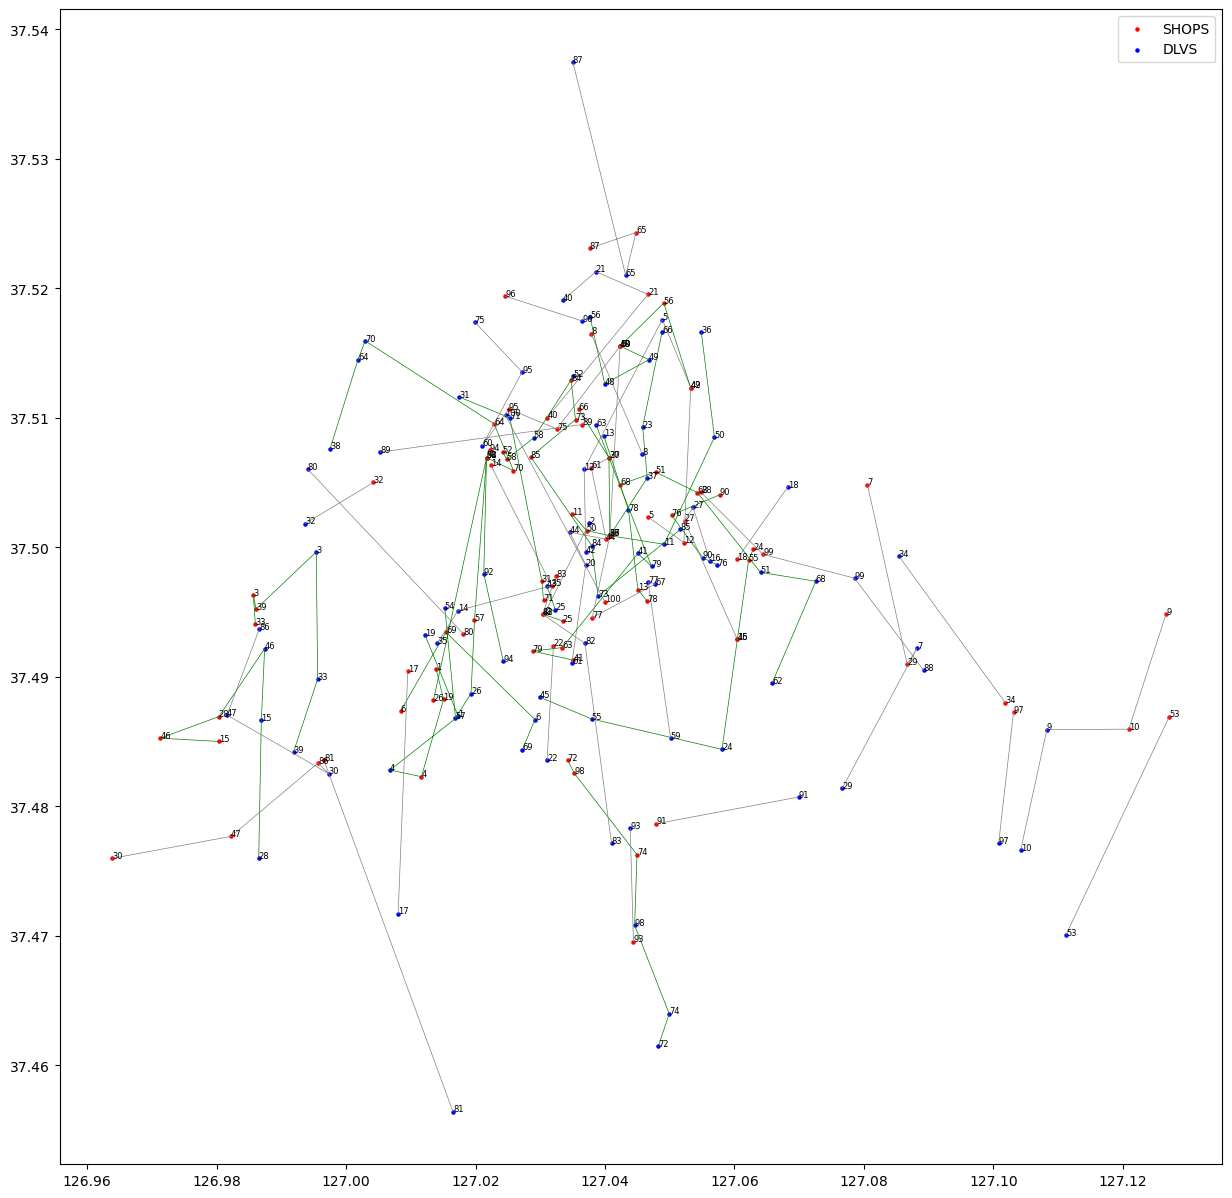

In [58]:
draw_route_solution2(ALL_ORDERS, checked_solution)